## Imports

In [204]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import sys
sys.path.insert(1, '..')

from scipy.stats import beta
from scipy.stats import lognorm
import h5py
import corner
import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)
#sns.set_context('notebook')
#sns.set(style="white", palette="muted")
from scipy import stats
import get_wavelet_params as wp
from matplotlib import rc
from astropy import constants as const

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

## Helper functions

In [205]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

def EllString(ell):
    return str(ell).replace('.','p')

def GetBaseDir(ell, SNR, res=None, seglen=None):
    ell = EllString(ell)
    SNR = str(SNR)
    
    base_dir = "/home/maria.okounkova/public_html/dCS_" + ell + "_SNR_" + SNR \
               + "/trigtime_1197495364.000000000_0.0_0.0_0/"  
    if (seglen != None):
        base_dir = "/home/maria.okounkova/public_html/dCS_" + ell + "_SNR_" + SNR + "_Seglen8" \
               + "/trigtime_1197495364.000000000_0.0_0.0_0/"    
    if (res != None):
        base_dir = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_" + ell \
                + "_Lev" + str(res) + "/dCS_" + ell + "_SNR_" + SNR + "/trigtime_1197495364.000000000_0.0_0.0_0/"
        
 
    return base_dir

def EllinKm(ell, string=True):
    """ 1 * G * (68 solar masses) / c^2 = 100.4 km"""
    val = ell * 100.4
    if string:
        return "%.1f km" % val
    else:
        return val

## Plot BW reconstructed waveforms

In [ ]:
def GetMedianData(ell, SNR, seglen=None):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    base_dir = GetBaseDir(ell, SNR, seglen=seglen)
 
    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_L1.dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1, d2, d3, d4, d5


def GetInjectedData(ell, SNR, seglen=None):
    
    base_dir = GetBaseDir(ell, SNR, seglen=seglen)
    print(base_dir)
    
    f = base_dir + 'post/whitened_data_L1.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data
    
def PlotMedianData(ax, ell, SNR, c):
    
    ## Plot the Bayeswave data
    time, d1, d2, d3, d4, d5 = GetMedianData(ell, SNR)
    label = r'$\ell$ = ' + EllinKm(ell) + ', SNR = ' + str(SNR) 
    
    ax.plot(time, d1, '-', lw = 1.0, alpha = 1.0, c=c, label=label)  
    ax.fill_between(time, d2, d3, alpha = 0.3, color=c, edgecolor=None)
    ax.fill_between(time, d4, d5, alpha = 0.2, color=c, edgecolor=None)
    
    time, data = GetInjectedData(ell, SNR)
    ax.plot(time, data, '--', color='black', lw = 1.0, alpha=1.0)
    ax.set_xlim(-0.05, 0.02)
    ax.legend(frameon=True, fontsize=16, loc='upper left')
        
fig, axarr = plt.subplots(2, 3, figsize=(20, 10), sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

snr_high = 100
snr_low = 20
PlotMedianData(axarr[0][0], 0.0, snr_high, 'blue')
PlotMedianData(axarr[0][1], 0.1, snr_high, '#148c8a')
PlotMedianData(axarr[0][2], 0.226, snr_high, '#45ba7e')
PlotMedianData(axarr[1][0], 0.0, snr_low, 'blue')
PlotMedianData(axarr[1][1], 0.1, snr_low, '#148c8a')
PlotMedianData(axarr[1][2], 0.226, snr_low, '#45ba7e')

#plt.legend(frameon=False, fontsize=20)
plt.ylabel('Median reconstructed waveform in L1')
for i in range(3):
    axarr[1][i].set_xlabel('$t - t_\mathrm{peak}$ (sec)')

plt.tight_layout()
plt.savefig('Bayeswave.pdf')

plt.show()



## Plot evidences

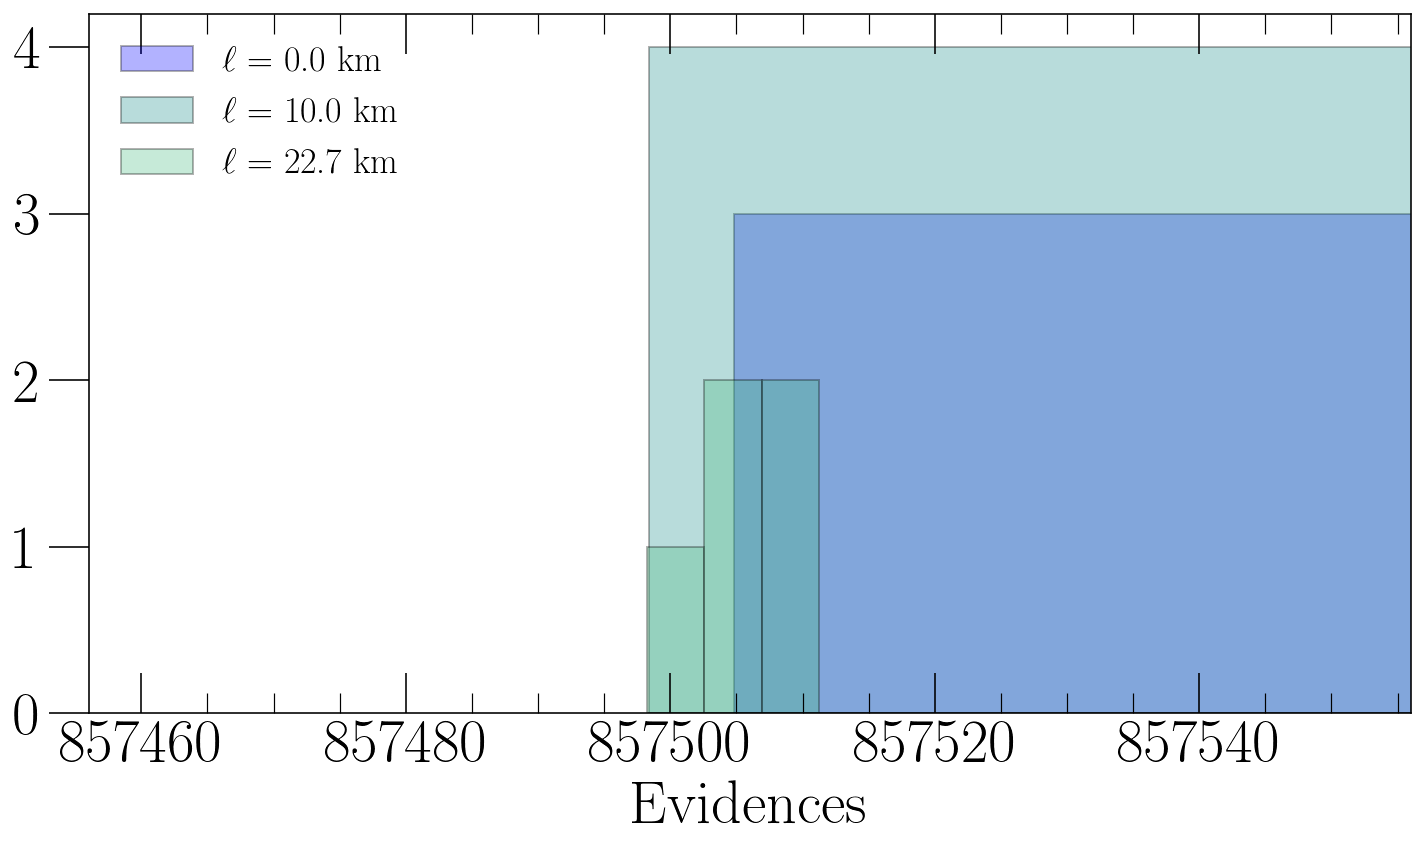

In [207]:
def GetEvidence(ell, SNR):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "signal_evidence.dat"
    ev = np.loadtxt(f, comments="#",usecols=([1]),unpack=True)[0]
    return ev
    
## Histogram the evidences for the BW case
plt.figure(figsize=(10,6))
ells = [0.0, 0.1, 0.226]
snrs = [20, 50, 80, 100, 150]
lim = 0.0
colors = ['blue', '#148c8a', '#45ba7e']
for ell, color in zip(ells, colors):
    evidences = []
    for SNR in [20, 50, 80, 100, 150]:
        ev = GetEvidence(ell, SNR)
        evidences.append(ev)
    n, bins, patches = plt.hist(evidences, 3, stacked = True, facecolor=color, \
                            alpha=0.3, edgecolor='black', label='$\ell$ = ' + EllinKm(ell))
    lim = np.average(evidences)

plt.xlim(lim -50, lim + 50)
plt.xlabel('Evidences', fontsize=30)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('Evidences.pdf')
plt.show()

    

## Compute overlaps

## Grab frequency domain data

In [ ]:
def GetPSD(ell, SNR, detector, cut = True):
    
    """ Get the PSD from the same place that megaplot.py 
        gets it from. See lines 1565 - 1569 in megaplot.py
        in the ain() method 
        
        Now if 'cut' is True, then set the PSD to 1 before
        125 Hz, which is approximately where we see a difference in the 
        waveform
        """
    
    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "post/signal/signal_median_PSD_" + detector + ".dat"
    freq, val = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True)
    
    if cut:
        index = np.where(freq < 125)[0]
        val[index] = 1.0
        
    return freq, val

def GetBWFrequencyDomainSpectrum(ell, SNR, detector):
    
    """ Get the bayeswave result frequency domain waveform from the 
    same place that megaplot.py gets it from. See lines 1559 - 1563 of
    megaplot.py in the main() method """
    
    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_spectrum_" \
                                                               + detector + ".dat"
    freq, re, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    return freq, re, d2, d3, d4, d5

def GetBWFrequencyDomainWaveform(ell, SNR, detector):
    
    """ Ignore the first column, it's wrong. The second line is the median with alternating real and imaginary waveforms
    The first line is h_R at f=0, the second line is h_I at f=0 etc """
    
    base_dir = GetBaseDir(ell, SNR)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_" \
                                                               + detector + ".dat"
    freq, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    length = len(freq)
    
    ## Grab the true frequency range
    freq = freq[0:int(length/2)]
    
    ## Now split up the median into real and imaginary parts
    d1 = d1[0::2] + 1j*d1[1::2]
    d2 = d2[0::2] + 1j*d2[1::2]
    d3 = d3[0::2] + 1j*d3[1::2]
    d4 = d4[0::2] + 1j*d4[1::2]
    d5 = d5[0::2] + 1j*d5[1::2]
    return freq, d1, d2, d3, d4, d5

def GetInjectedFrequencyDomainWaveform(ell, SNR, detector, res=None):
    
    """ Get the injected frequency domain waveform from the same
    place that megaplot.py gets it from. See lines 541 - 543 of
    megaplot.py in plot_full_spectro() method """

    base_dir = GetBaseDir(ell, SNR, res=res)
 
    f = base_dir + "waveforms/fourier_domain_data_" + detector + ".dat"
    freq, re, im = np.loadtxt(f, comments="#",usecols=([0,1,2]),unpack=True)
    return freq, re + 1j*im   

## Plot frequency domain data

In [ ]:
def PlotFrequencyData(ax, ell, SNR, color):
    
    label = r'$\ell$ = ' + EllinKm(ell) + ', SNR = ' + str(SNR)
    
    freq, psd = GetPSD(ell, SNR, "L1")
    freq, bw, d2, d3, d4, d5 = GetBWFrequencyDomainSpectrum(ell, SNR, "L1")
    freq, inj = GetInjectedFrequencyDomainWaveform(ell, SNR, "L1")
    
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    ax.plot(freq, psd, color='grey')
    ax.plot(freq, bw, label = label, color=color)
    ax.fill_between(freq, d2, d3, alpha = 0.3, color=color, edgecolor=None)
    ax.fill_between(freq, d4, d5, alpha = 0.2, color=color, edgecolor=None)
    ax.plot(freq, op(inj), color='black', ls='--', lw=1.0) 
   
    
    #freq, bayes = GetBWFrequencyDomainWaveform(ell, SNR, "L1")
    #ax.plot(freq, np.real(bayes)**2 + np.imag(bayes)**2)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(20, 1000)
    ax.set_ylim(1e-58, 1e-42)
    ax.legend(frameon=True, fontsize=16, loc='upper left')

fig, axarr = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)

snr_high = 100
snr_low = 50
PlotFrequencyData(axarr[0][0], 0.0, snr_high, 'blue')
PlotFrequencyData(axarr[0][1], 0.1, snr_high, '#148c8a')
PlotFrequencyData(axarr[0][2], 0.226, snr_high, '#45ba7e')
PlotFrequencyData(axarr[1][0], 0.0, snr_low, 'blue')
PlotFrequencyData(axarr[1][1], 0.1, snr_low, '#148c8a')
PlotFrequencyData(axarr[1][2], 0.226, snr_low, '#45ba7e')

#plt.legend(frameon=False, fontsize=20)
#plt.ylabel('Power in L1')
for i in range(3):
    axarr[1][i].set_xlabel('Frequency [Hz]')
for i in range(2):
    axarr[i][0].set_ylabel('Power in L1')

plt.tight_layout()
plt.savefig('BayeswaveFreq.pdf')

plt.show()


## Compute overlaps

In [ ]:

def InnerProduct(freq, hA, hB, PSD):

    """ Compute the inner product using the conventions of 
    https://arxiv.org/abs/2003.09456 Eq. 8"""
    
    ## Spacing in frequency
    df = freq[1] - freq[0]
    
    ## Terms inside the integral
    product = hA * np.conj(hB) / PSD 
    
    ## Compute the integral 
    total = 4.0 * np.real(np.sum(product)) * df
    return total
    
def Overlap(ell, SNR):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    total_bw_inj = 0.0
    total_bw_bw = 0.0
    total_inj_inj = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, SNR, detector)
        freq, bw, d2, d3, d4, d5 = GetBWFrequencyDomainWaveform(ell, SNR, detector)
        freq, inj = GetInjectedFrequencyDomainWaveform(ell, SNR, detector)
        
        total_bw_inj = total_bw_inj + InnerProduct(freq, bw, inj, psd)
        total_bw_bw = total_bw_bw + InnerProduct(freq, bw, bw, psd)
        total_inj_inj = total_inj_inj + InnerProduct(freq, inj, inj, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_bw_inj / np.sqrt(total_bw_bw  * total_inj_inj)
    return overlap
    

plt.figure(figsize=(12, 5))
SNRs = [20, 50, 80, 100]

ells = [0.0, 0.1, 0.226]
colors = ['blue', '#148c8a', '#45ba7e']
for ell, c in zip(ells, colors):
    
    ## compute the overlap for the median waveform
    deltas = [1.0 - Overlap(ell, snr) for snr in SNRs]
    plt.plot(SNRs, deltas, '--o', color=c, label=r'$\ell$ = ' + EllinKm(ell), markersize=10)
    
## Add in 1/SNR^2 curve 
snrs = np.linspace(SNRs[0], SNRs[-1], 100)
snr_curve = snrs**-2.0
plt.plot(snrs, snr_curve*100, color='black')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$\Delta_\mathrm{B,I}$')
plt.xlabel('SNR')
plt.tight_layout()
plt.savefig('Deltas.pdf')

plt.show()
    

## Plot injection bank

In [ ]:

fig, ax = plt.subplots(figsize=(7,5))
ells = [0.0, 0.1, 0.226]
snrs = [20, 50, 80, 100, 150]
for ell in ells:
    plt.scatter(snrs, [EllinKm(ell, string=False) for s in snrs], color='red', marker='*', s=200)
plt.xlabel('SNR', fontsize=30)
plt.ylabel('$\ell$ [km]', fontsize=30)

snr_low = 10
snr_high = 160
l_low = -2
l_high = 28

rect = plt.Rectangle((snr_low, 22.7), snr_high - snr_low, 10,
                     facecolor="red", alpha=0.1)
ax.add_patch(rect)

plt.ylim(l_low, l_high)
plt.xlim(snr_low, snr_high)
plt.tight_layout()
plt.savefig('Banks.pdf')
plt.show()


## Plot the injected waveforms for various NR resolutions and compute the mismatches

In [ ]:
def GetResInjectedData(ell, SNR, res):
    
    base_dir = GetBaseDir(ell, SNR, res=res)
    
    f = base_dir + 'post/whitened_data_L1.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data
    
def PlotResInjectedData(ell, SNR, res, color, ls, label):
    
    ## Plot the Bayeswave data
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    freq, data = GetInjectedFrequencyDomainWaveform(ell, SNR, 'L1', res=res)
    plt.plot(freq, op(data), lw = 3.0, alpha=1.0, label=label, \
                color = color, ls = ls)
    
fig, ax = plt.subplots(1, figsize=(10, 10), sharex=True)

cs = sns.color_palette('husl', n_colors=6)
    
i = 0
SNR = 150
for ell, label, ls in zip([0.0, 0.226], ['GR', 'dCS-modified'], ['-', '--']):
        
    for lev, res in zip([0,1,2], ['Low', 'Med', 'High']):
        
        lab=label+', ' + res
        PlotResInjectedData(ell, SNR, lev, color=cs[i], ls=ls, label=lab)
        i = i + 1

## Plot the noise curve
freq, psd = GetPSD(0.0, SNR, "L1", cut=False)
plt.plot(freq, psd, color='black', ls = '-', lw = 7.0, label='PSD', alpha=0.4)

freq, psd = GetPSD(0.0, SNR, "L1")
plt.plot(freq, psd, color='black', ls = '--', lw = 1.4, label='Restricted PSD')

plt.xlabel('Frequency [Hz]', fontsize=30) 
plt.ylabel(r'L1 Injected', fontsize=30)

plt.ylim(7e-48, 2e-46)
plt.xlim(100, 350)
plt.legend(loc='upper right', frameon=False)
plt.yscale('log')

## Put text in about the mismatches - from the cell below
## 5.85301418321027e-06
## 8.885879811848518e-06
## 0.00042500416098467664
plt.text(110, 2e-47, r'GR-GR mismatch: $5.85 \times 10^{-6} $', fontsize=24)
plt.text(110, 1.65e-47, r'dCS-dCS mismatch: $8.88 \times 10^{-6} $', fontsize=24)
plt.text(110, 1.2e-47, r'GR-dCS mismatch: $4.25 \times 10^{-4} $', fontsize=24)

plt.tight_layout()
plt.savefig('Injected.pdf')

plt.show()

## Resolution overlaps

In [ ]:
def ResolutionOverlap(SNR, ell1, ell2, res1, res2):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    def op(w):
        return np.real(w)**2 + np.imag(w)**2
    
    total_11 = 0.0
    total_12 = 0.0
    total_22 = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, SNR, detector)
        
        freq, inj1 = GetInjectedFrequencyDomainWaveform(ell1, SNR, detector, res = res1)
        inj1 = op(inj1)
        freq, inj2 = GetInjectedFrequencyDomainWaveform(ell2, SNR, detector, res = res2)
        inj2 = op(inj2)
        
        total_11 = total_11 + InnerProduct(freq, inj1, inj1, psd)
        total_12 = total_12 + InnerProduct(freq, inj1, inj2, psd)
        total_22 = total_22 + InnerProduct(freq, inj2, inj2, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_12 / np.sqrt(total_11  * total_22)
    return 1 - overlap

def ResolutionOverlapFigure():

    plt.figure(figsize=(8, 4))
    
    SNR = 150
    
    def Line(ell1, ell2, label, color):
        data = [ResolutionOverlap(150, ell1, ell2, 0, 2), ResolutionOverlap(150, ell1, ell2, 1, 2)]
        print(ResolutionOverlap(150, ell1, ell2, 1, 2))
        plt.plot([0,1], data, '-o', label = label, color=color)
    
    ell = 0.226
    Line(0.0, 0.0, 'GR, GR', 'black')
    Line(ell, ell, 'dCS, dCS', 'gray')
    Line(0.0, ell, 'GR, dCS', 'red')
    
    plt.yscale('log')
    plt.xticks([0, 1], ['Lev0 - Lev2', 'Lev1 - Lev2'], rotation = 90)
    plt.xlim(-0.5, 1.5)
    plt.ylabel('1 - Overlap')
    plt.legend()
    plt.show()
    

ResolutionOverlapFigure()

print(4e-4)


## Comparison with LALInference

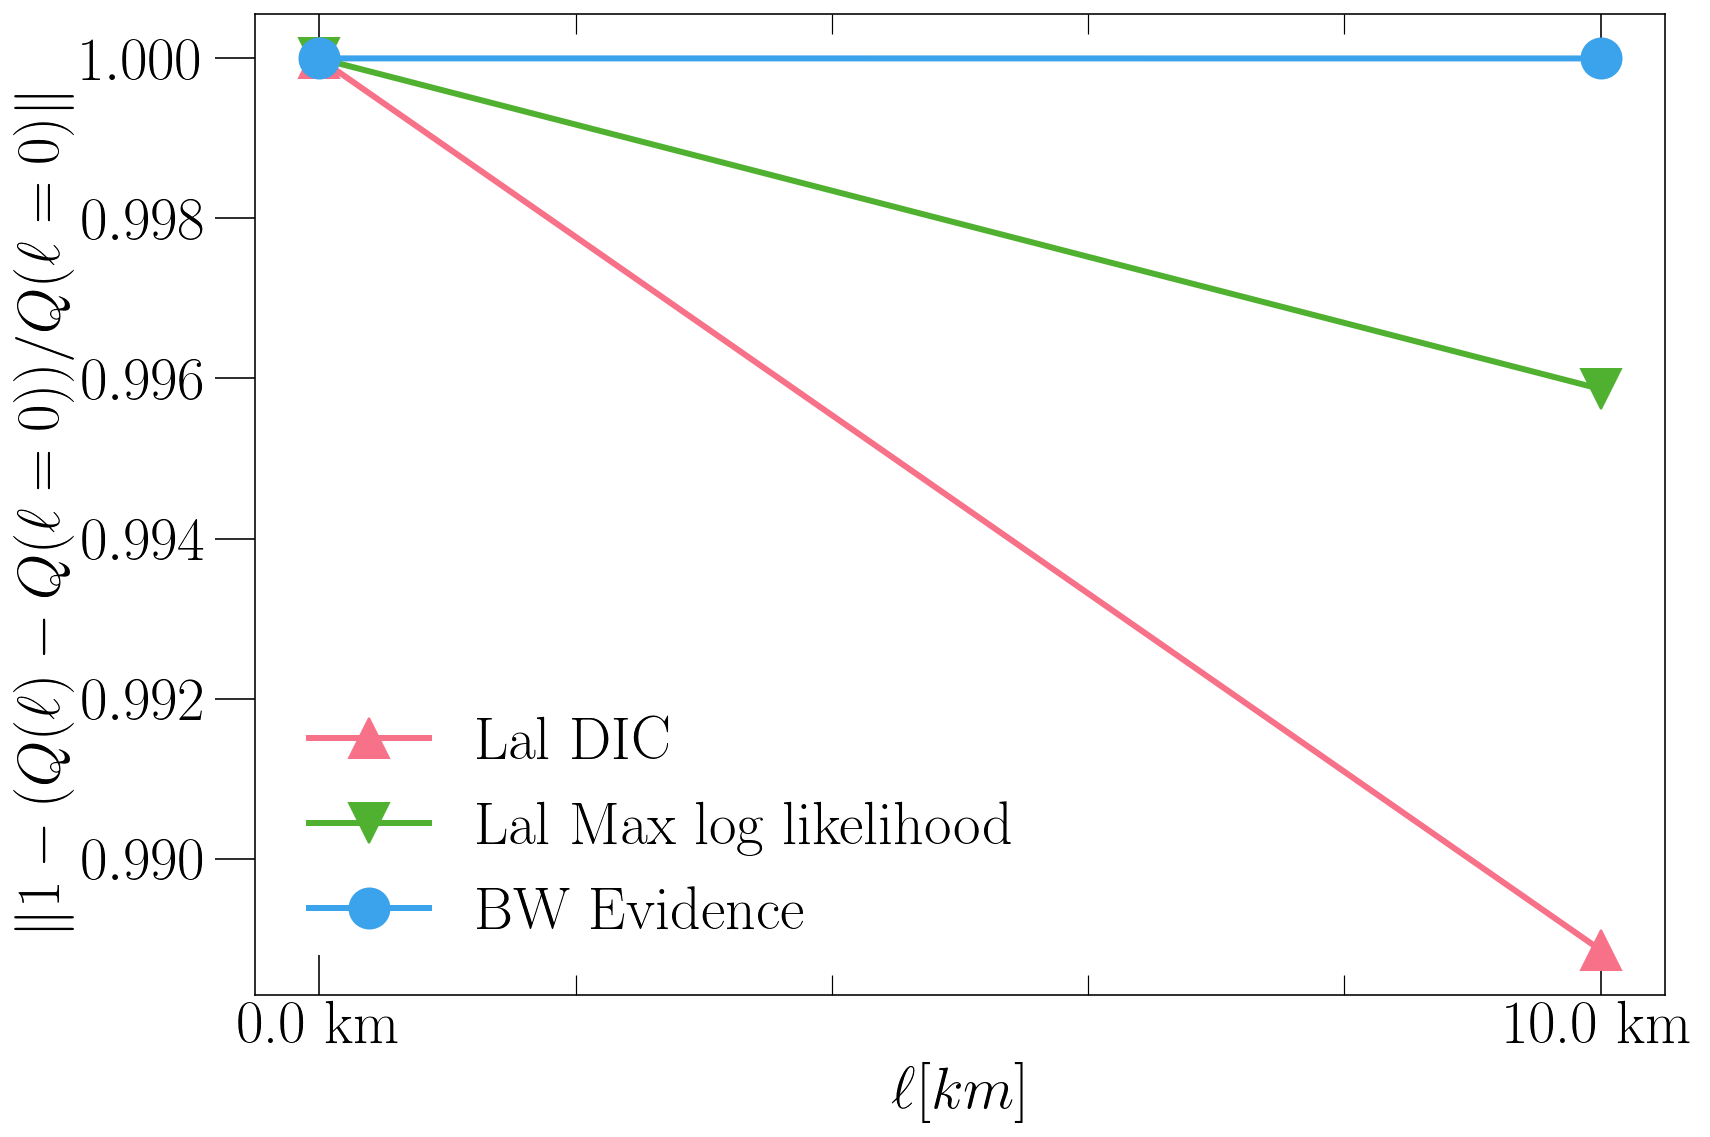

In [223]:
## Compare the DIC and Bayes' factors

def PlotDICBayes():
    
    fig = plt.figure(figsize=(12, 8))
    
    ell = [0.0, 0.1]
    ell_km = [EllinKm(l) for l in ell]
    
    DIC = np.array([98.7, 97.6])
    ## log likelihoods
    Max_Log_Likelihood = np.array([-39.8804, -39.7156]) 
    ## BW evidences
    BW_Evidence = np.array([GetEvidence(l, 100) for l in ell])
    
    cs = sns.color_palette('husl', n_colors=3)
    
    def relative(X):
        return 1 - abs((X - X[0])/X[0])
    
    Max_Log_Likelihood = relative(Max_Log_Likelihood)
    DIC = relative(DIC)
    BW_Evidence = relative(BW_Evidence)
    

    plt.plot(ell_km, DIC, marker = '^', color= cs[0], label= 'Lal DIC', markersize=20)
    plt.plot(ell_km, Max_Log_Likelihood, marker = 'v', color = cs[1], label= 'Lal Max log likelihood', markersize=20)
    plt.plot(ell_km, BW_Evidence, marker = 'o', color = cs[2], label= 'BW Evidence', markersize=20)
    
    #for ax in axarr:
    #    ax.legend(frameon=False, fontsize=30)

    
    #plt.yscale('log')
    plt.ylabel(r'$\|1 - (Q(\ell) - Q(\ell = 0))/Q(\ell = 0)\|$', fontsize=30)
    plt.xlabel(r'$\ell [km]$', fontsize=30)
    plt.legend(frameon=False, fontsize=30)
    plt.tight_layout()
    plt.savefig('DICBF.pdf') 
    plt.show()
    
PlotDICBayes()

## LALInference posteriors

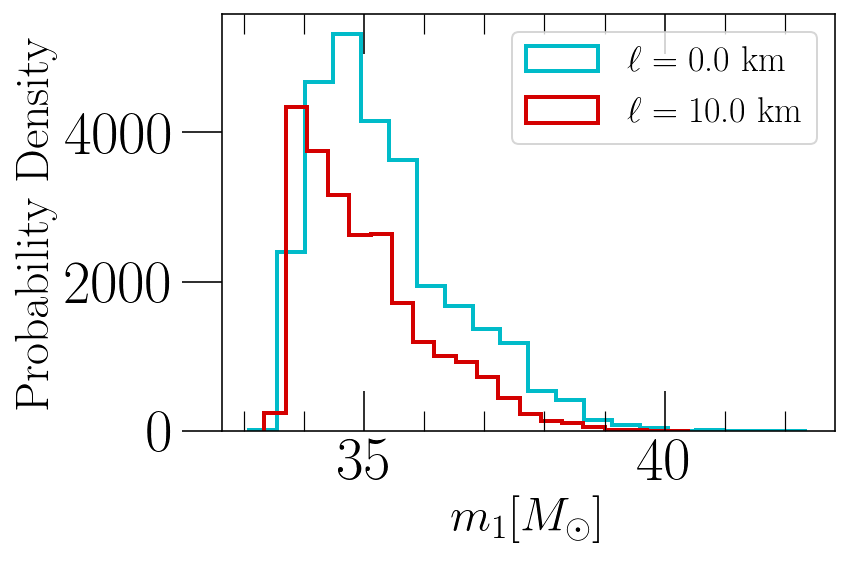

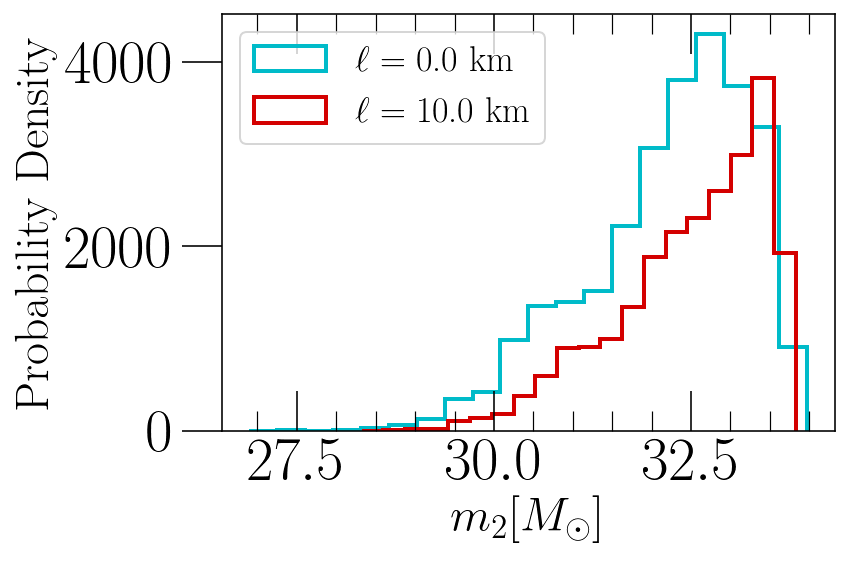

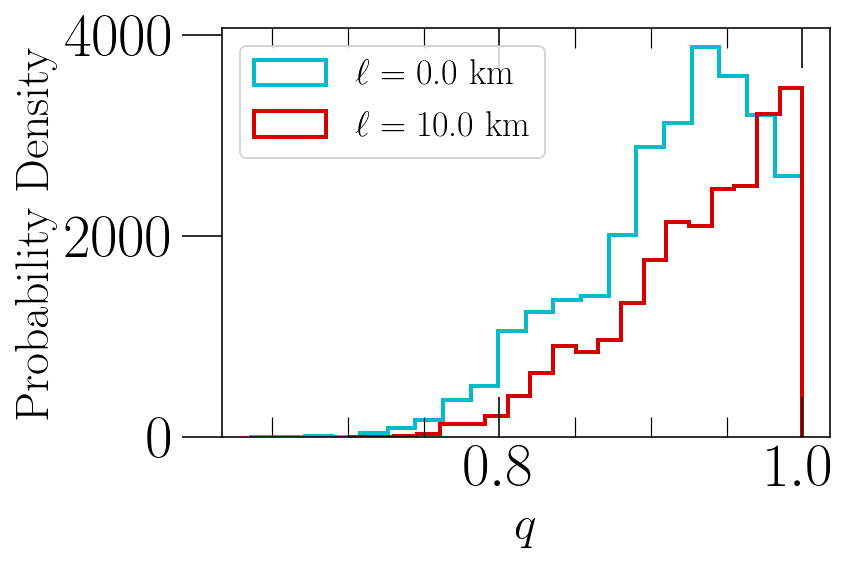

In [225]:
TruthDict = {'m1' : 37.386085075316785, 'm2' : 30.613915574190038, 'mc' : 29.42222678574253, 'mtotal' : 68.0, 'q' : 1.0/1.2212121309577342, \
             'chi_eff' : 0.0, 'a1' : 0.329894028067, 'a2' : 0.439941681413, 'af_nonevol' : 0.692}
LabelDict = {'m1' : r"$m_1 [M_\odot]$", 'm2' : r"$m_2 [M_\odot] $", 'mc' : r"$\mathcal{M} [M_\odot]$", 'mtotal' : r"$M [M_\odot]$", 'q' : r"$q$", \
             'chi_eff' : r"$\chi_\mathrm{eff}$", 'a1' : r"$a_1$", 'a2' : r"$a_2$", 'af_nonevol' : r"$a_f$"}


def FindPosteriorIndex(string):
        f = '/home/maria.okounkova/public_html/dCS_0p0_SNR_100/LAL/posterior_samples.dat'
        with open(f) as file:
            labels = file.readline().split()
        return labels.index(string)
    
def ReadPosteriorData(string, ell):
    index = FindPosteriorIndex(string)
    f = '/home/maria.okounkova/public_html/dCS_' + EllString(ell) + '_SNR_100/LAL/posterior_samples.dat'
    data = np.loadtxt(f, comments="#",usecols=([index]),unpack=True, skiprows=1)
    return data

def Posteriors(quantity):

    def histogram(ell, color):
        data = ReadPosteriorData(quantity, ell)
        nbins = 20
        H = plt.hist(data, color=color, alpha=1.0, linewidth=2.0, histtype=u'step', density=False, bins = nbins, label=r'$\ell = $ ' + EllinKm(ell))
        H = plt.hist(data, color=color, alpha=0.0, density=False, bins = nbins)
        
    plt.figure(figsize=(6,4))
    histogram(0.0, "#00bbc9")
    histogram(0.1, "#D40000")
    plt.legend(loc='best', ncol=1, fontsize=18)
    plt.ylabel('Probability Density')
    plt.xlabel(LabelDict[quantity])
    plt.tight_layout()
    plt.savefig('Hist_' + quantity + '.pdf')
    plt.show()
    
    
#Posteriors(20, 'Mass Ratio', 'MassRatio', 0.8188585542593252)
Posteriors('m1')
Posteriors('m2')
Posteriors('q')

In [226]:
def GetDataForMassCorner(ell, quants):
    labels = [LabelDict[q] for q in quants]
    truths = [TruthDict[q] for q in quants]
    vals = np.vstack([ReadPosteriorData(q, ell) for q in quants]).transpose()
    return vals, labels, truths
    

In [227]:
def CornerPlot(quantities, figname):
    data_0p0, labels, truths = GetDataForMassCorner(0.0, quantities)
    data_0p1, labels, truths = GetDataForMassCorner(0.1, quantities)
    
    cs = sns.color_palette('husl', n_colors=2)
    
    dim = len(labels)
    ranges = [1.0 for d in labels]

    fig = corner.corner(data_0p0, labels=labels,
                       title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=cs[0], 
                       show_titles=False)
    corner.corner(data_0p1, fig=fig, range = ranges, color=cs[1],
                 #truths = truths, truth_color = '#cccacb'
                 )
    
    ax_arr = fig.get_axes()
    
    ## scatter the truths
    for cc in range(1, dim):
        for rr in range(cc):
            ax_arr[cc*dim + rr].scatter([truths[rr]], [truths[cc]], color = 'black', s=200, marker='*')
            
    for rr in range(dim):
        ax_arr[rr*dim + rr].axvline(truths[rr], ls='--', lw=1.0, color='black')
    
    ## add in the legend
    x = [0.0, 0.0]
    y = [0.0, 0.0]
    l1 = ax_arr[0].plot(x, y, label=EllinKm(0.0), color = cs[0])
    l2 = ax_arr[0].plot(x, y, label=EllinKm(0.1), color = cs[1])
    legend = ax_arr[1].legend(handles=[l1[0], l2[0]], title = '$\ell$', frameon=False)
    plt.setp(legend.get_title(),fontsize=20)

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()

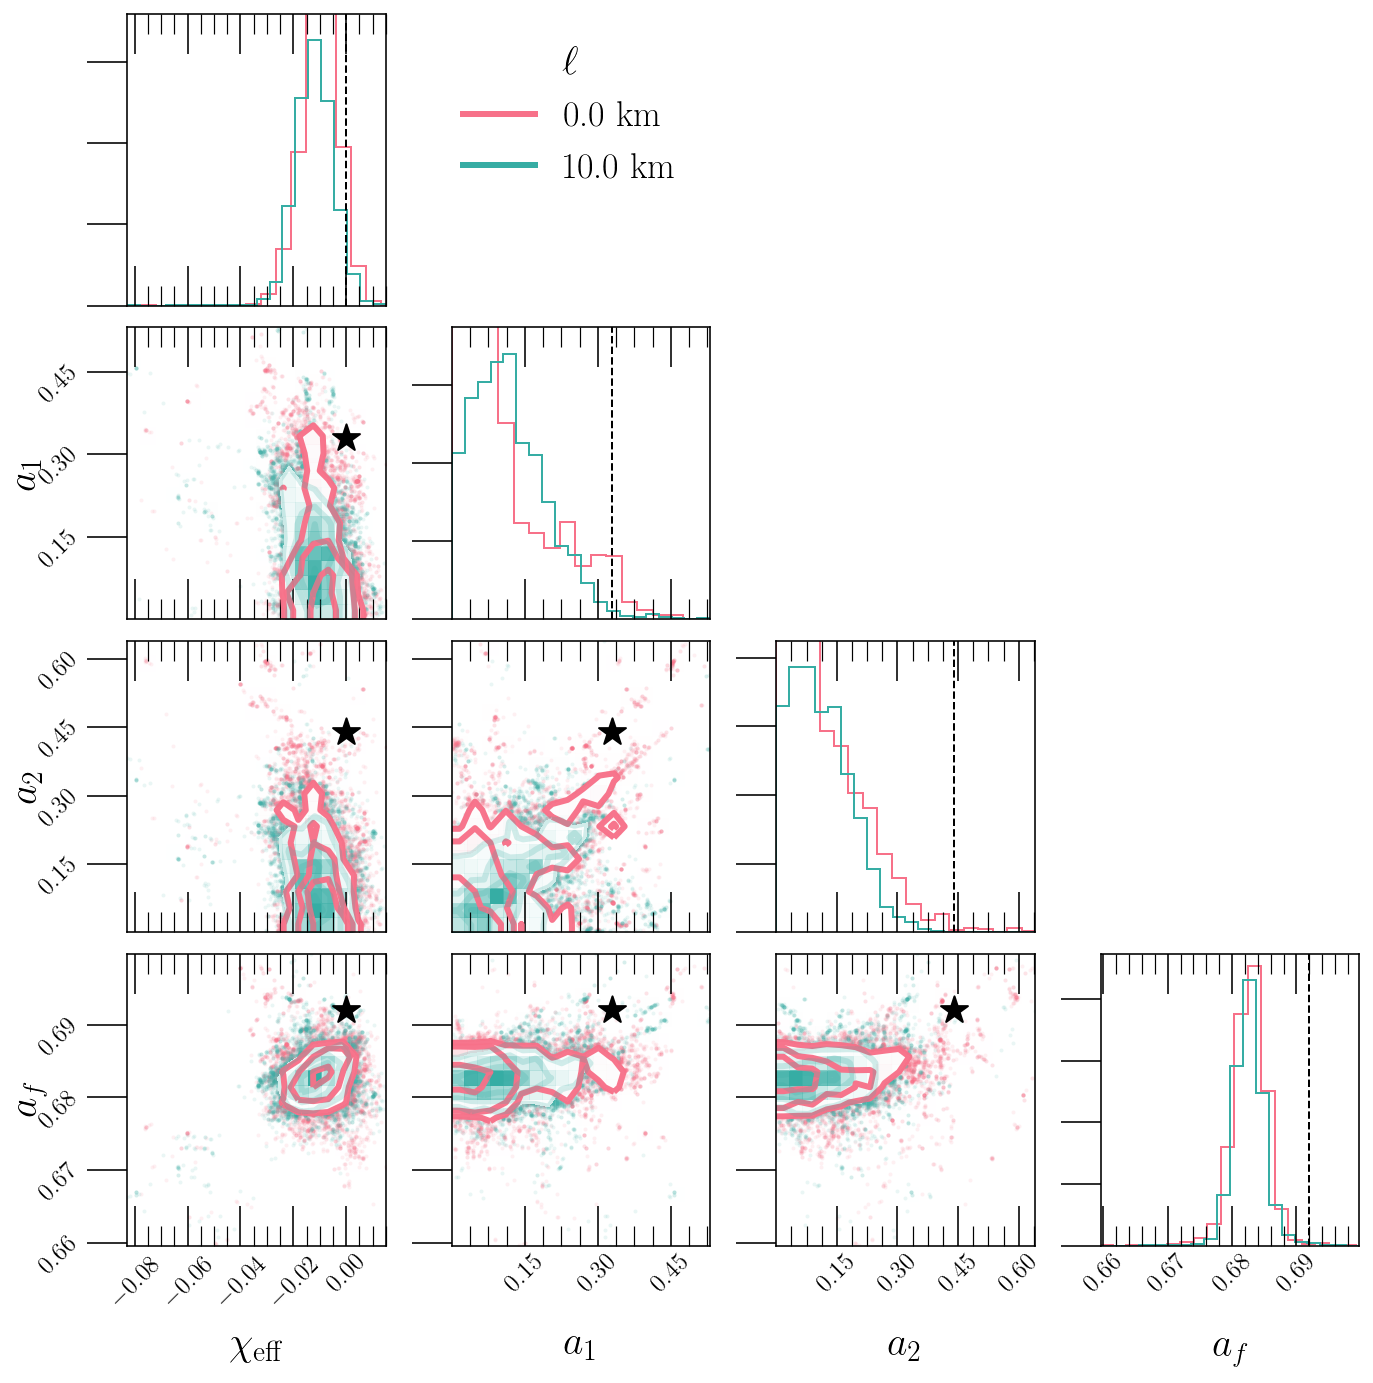

In [189]:
CornerPlot(['chi_eff', 'a1', 'a2', 'af_nonevol'], 'SpinCorner')

In [ ]:
CornerPlot(['m1', 'm2', 'mc', 'mtotal', 'q'], 'MassCorner')